[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/10WQw-s7EQtb_B9Kg8h-_zydX3mC0tZRh)

# **Flower Classifier - Test Your Own Images**

In this notebook, we evaluate and compare the performance of **Convolutional Neural Networks (CNNs)** and **Vision Transformers (ViTs)** for the task of flower classification.

## 00. Preacquisition


### Dataset Overview 📁🥀

The dataset consists **102 distinct flower species**, providing a diverse set of images for model testing. Below is a sample of the flower categories available in the dataset:

<div style="text-align: center;">
    <img src="https://drive.google.com/uc?export=view&id=16V6Bo3L1_HLN4O8CZz5ik4F9Qkz_YUL6">
</div>

### Common Misclassifications ❌🚫

Certain flower species tend to be misclassified more frequently, often due to visual similarities. Here are examples of such cases to be aware of:

![Misclassification Example](https://drive.google.com/uc?export=view&id=1dqLz4Op0N6SaMUk8vg9xOHQ96E5P2swU)

## 01. Enviroment Setup

🔌Mount your drive to access project files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


📂 Now, browse to the working directory

In [ ]:
# Your path to FlowerLover
%cd '/content/drive/MyDrive/FlowerLover/'

/content/drive/MyDrive/FlowerLover


📦 Install and import neccesary libraries

In [ ]:
!pip install torch torchvision timm &>/dev/null

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

In [ ]:
import timm

import torch
from torch import nn

from torchvision import  transforms , models

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Custom Color Palette
custom_palette = [
    "#5b9e4e", "#a8dba8", "#f0b800", "#f8dd6c", "#f6b176",
    "#f88840", "#e93967", "#d41944", "#c4347c", "#fff2d5",
    "#d9d9d9", "#5ec2c1", "#3a96d9","#fde2e4", "#d3f8f2"]

## 02. Toolbox

### Mapping labels to their respective classes 🏷️🔢

In [ ]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

### Models Rebuiling 🏗️🧱

In [ ]:
def define_classifier(input_size, hidden_units=512, output_size=102, dropout_rate=0.5):
    return nn.Sequential(
        nn.Linear(input_size, hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_units, output_size),
        nn.LogSoftmax(dim=1)
    )

In [ ]:
# build and configure the model

def build_model(model_name='resnet50', hidden_units=512, output_size=102, dropout_rate=0.5, custom_classifier=True):
    # Load the pre-trained model
    if model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    elif model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_name == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    elif model_name == "vgg19":
        model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    else:
        raise ValueError("Unsupported model name!")

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Define and assign a new classifier only if requested
    if custom_classifier:
        if "resnet" in model_name:
            input_size = model.fc.in_features
            model.fc = define_classifier(input_size, hidden_units, output_size, dropout_rate)
        elif "vgg" in model_name:
            input_size = model.classifier[0].in_features
            model.classifier = define_classifier(input_size, hidden_units, output_size, dropout_rate)

    return model


In [ ]:
# Model builder for Vision Transformers
def build_transformer_model(model_name='vit_base_patch16_224', hidden_units=512, output_size=102, dropout_rate=0.5):
    # Load the pre-trained Transformer model from timm
    model = timm.create_model(model_name, pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Vision Transformers typically have a head named `head`
    input_size = model.head.in_features
    model.head = nn.Sequential(
        nn.Linear(input_size, hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_units, output_size),
        nn.LogSoftmax(dim=1)
    )

    return model

### Loading Model Checkpoints 🗃️🔄




In [ ]:
## Loading the checkpoint
def load_model(checkpoint_path):

    # Map the checkpoint to the appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Check if the model is a Vision Transformer based on its name
    if checkpoint['model_name'].startswith("vit") or "deit" in checkpoint['model_name']:
        # Build and load Vision Transformer
        model = build_transformer_model(model_name=checkpoint['model_name'])

    else:
        # Build and load CNN
        model = build_model(model_name=checkpoint['model_name'], custom_classifier=False)

        # Attach the saved classifier
        if "resnet" in checkpoint['model_name']:
            model.fc = checkpoint['classifier']
        elif "vgg" in checkpoint['model_name']:
            model.classifier = checkpoint['classifier']

    # Load the model weights
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)

    # Add class-to-index mapping
    model.class_to_idx = checkpoint['class_to_idx']

    return model


In [ ]:
vgg16 = load_model('saved_models/vgg16_checkpoint.pth')
resnet50 = load_model('saved_models/resnet50_checkpoint.pth')

vit_base_patch16_224 = load_model('saved_models/vit_base_patch16_224_checkpoint.pth')
deit_base_patch16_224 = load_model('saved_models/deit_base_patch16_224_checkpoint.pth')
vit_small_r26_s32_224 = load_model('saved_models/vit_small_r26_s32_224_checkpoint.pth')

models = {'vgg16':vgg16, 'resnet50':resnet50 ,'vit base patch16 224':vit_base_patch16_224 , 'deit base patch16 224': deit_base_patch16_224 , 'vit small r26 s32 224':vit_small_r26_s32_224 }

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 75.1MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 109MB/s]


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/146M [00:00<?, ?B/s]

### Processing Input Image 🖼️


In [ ]:
def process_image(image):

    image = Image.open(image)  # Open image if a path is provided

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return preprocess(image)

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):

    if ax is None:
        _ , ax = plt.subplots()

    # PyTorch tensors expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Thus, reordering dimensions using transpose
    image = image.numpy().transpose((1, 2, 0)) # Convert from (C, H, W) to (H, W, C)

    if normalize:
        # Reverse normalization (undo preprocessing)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)  # Clip the image values to the range [0, 1] to prevent display artifacts or noise

    ax.imshow(image)
    ax.axis('off')
    if title:
        ax.set_title(title)

    return ax


### Top-K Prediction 🥇

In [ ]:
# Predicting top-K most probable classes

def predict(image_path, model,top_k=5):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    tensor_image = process_image(image_path)
    tensor_image = tensor_image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(tensor_image)

    probabilities = torch.softmax(output, dim=1)
    top_probs, top_indices = probabilities.topk(top_k)

    top_probs = top_probs.squeeze().cpu().numpy()
    top_indices = top_indices.squeeze().cpu().numpy()

    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    classes = [idx_to_class[idx] for idx in top_indices]

    return top_probs, classes

### Sanity check across multiple models for comparison 🧠🧪

In [ ]:
def sanity_checking(image_path, models, top_k=5):

    # Extract real species name from image path
    label = image_path.split('/')[-2]  # Extract the label from the path
    real_species_name = cat_to_name.get(label, "Unknown Species")  # Map to species name

    num_models = len(models)

    # Create subplots: one for the image and one for each model
    _, axes = plt.subplots(1, num_models + 1, figsize=(5 * (num_models + 1), 5))

    # Process the image
    img = process_image(image_path)

    # Use the imshow function to display the processed image
    imshow(img, ax=axes[0], title=f"Flower Type: {real_species_name}")

    # Loop through models to generate predictions and bar charts
    for idx, (model_name, model) in enumerate(models.items(), start=1):
        # Predict using the current model
        probs, classes = predict(image_path, model, top_k)
        class_names = [cat_to_name.get(str(cls)) for cls in classes]

        # Bar chart for model predictions
        y_pos = np.arange(len(class_names))
        axes[idx].barh(y_pos, probs, align='center', color=custom_palette[:top_k])
        axes[idx].set_yticks(y_pos)
        axes[idx].set_yticklabels(class_names)
        axes[idx].invert_yaxis()  # Highest probability at the top
        axes[idx].set_xlabel('Probability')
        axes[idx].set_title(f"Model: {model_name}")

    # Adjust layout
    plt.tight_layout()
    plt.show()


##  03. Models Testing: Using Your Own Flower Photos


⚠️ Upload your images to the `assets` folder.

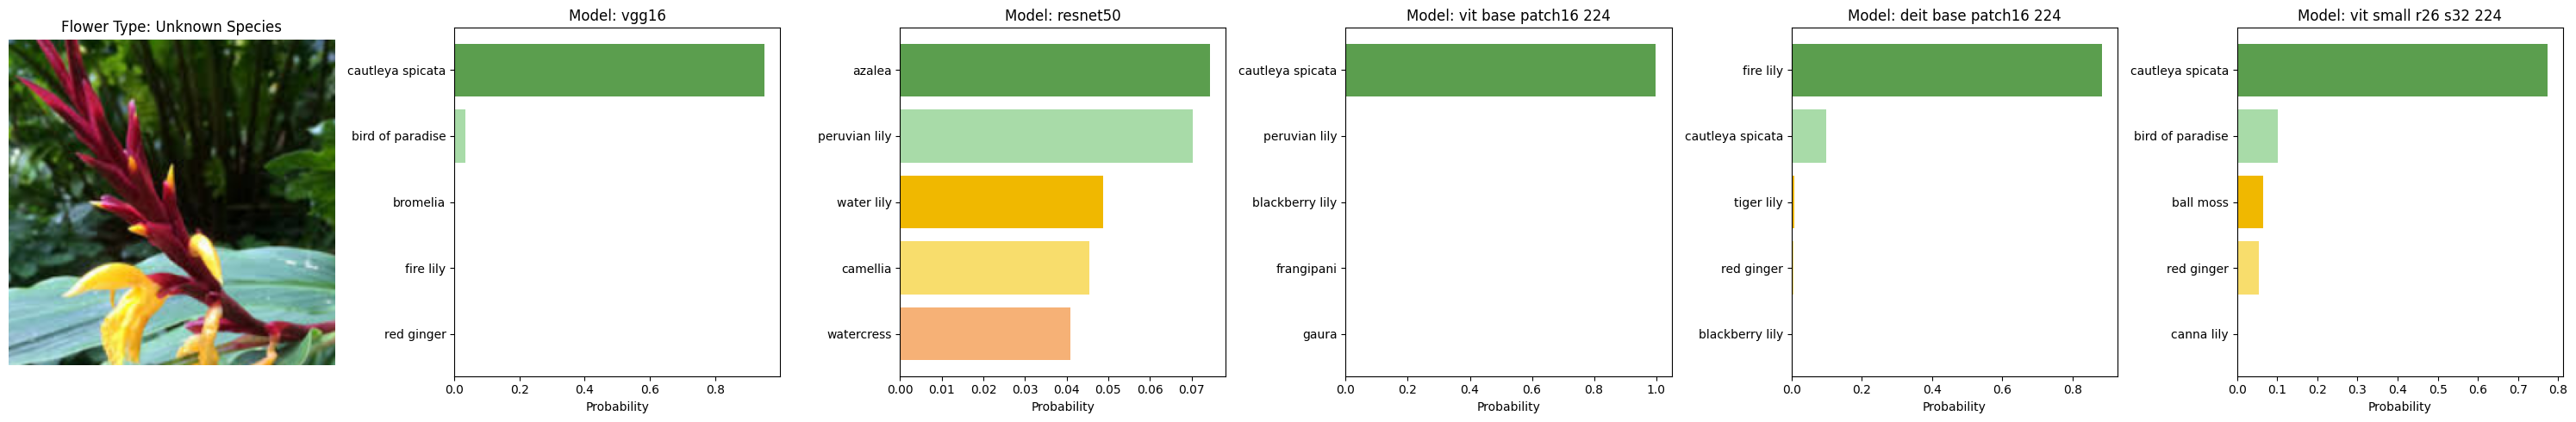

In [ ]:
sanity_checking('assets/Cautleya Spicata.jpg', models)

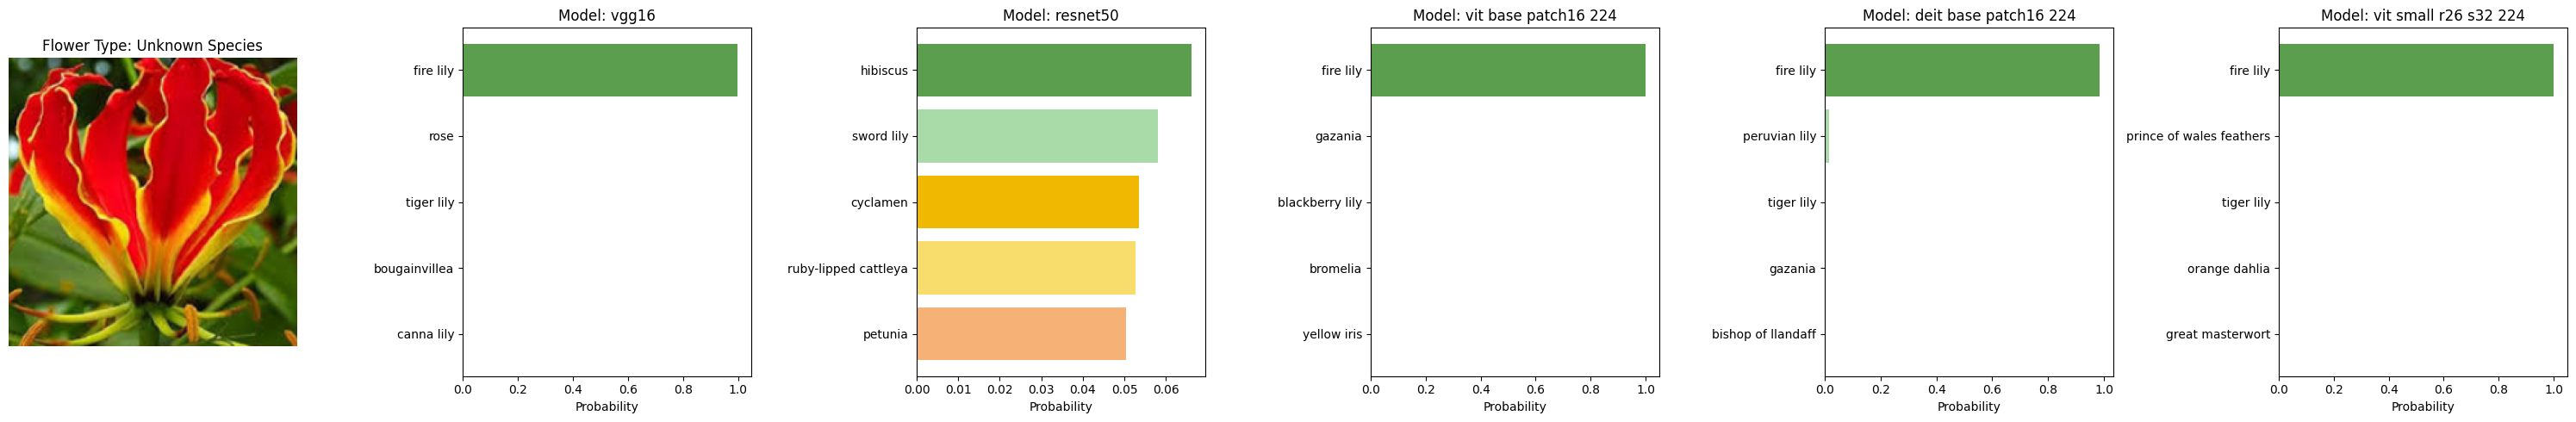

In [ ]:
sanity_checking('assets/download.jpg', models )

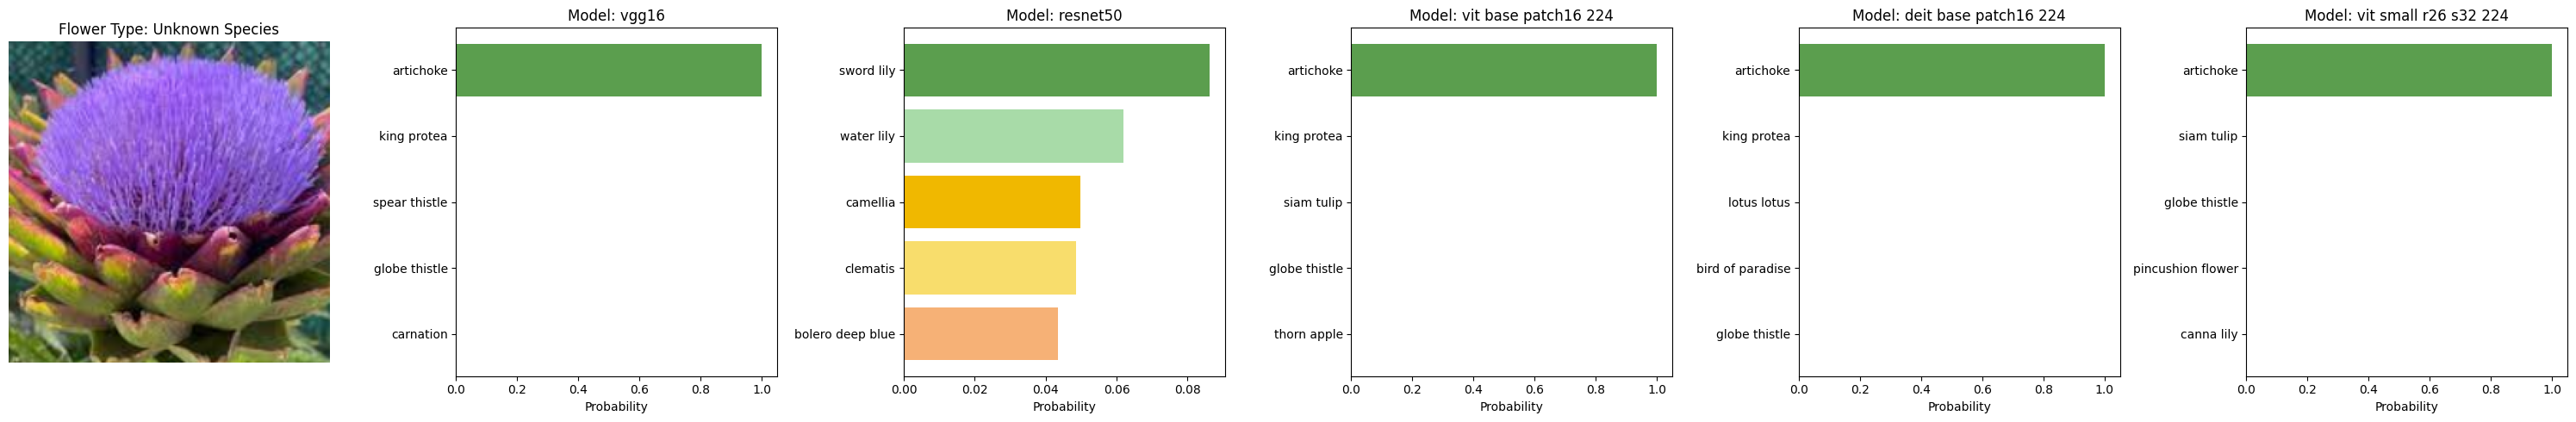

In [ ]:
sanity_checking('assets/Artichoke.jpg', models )

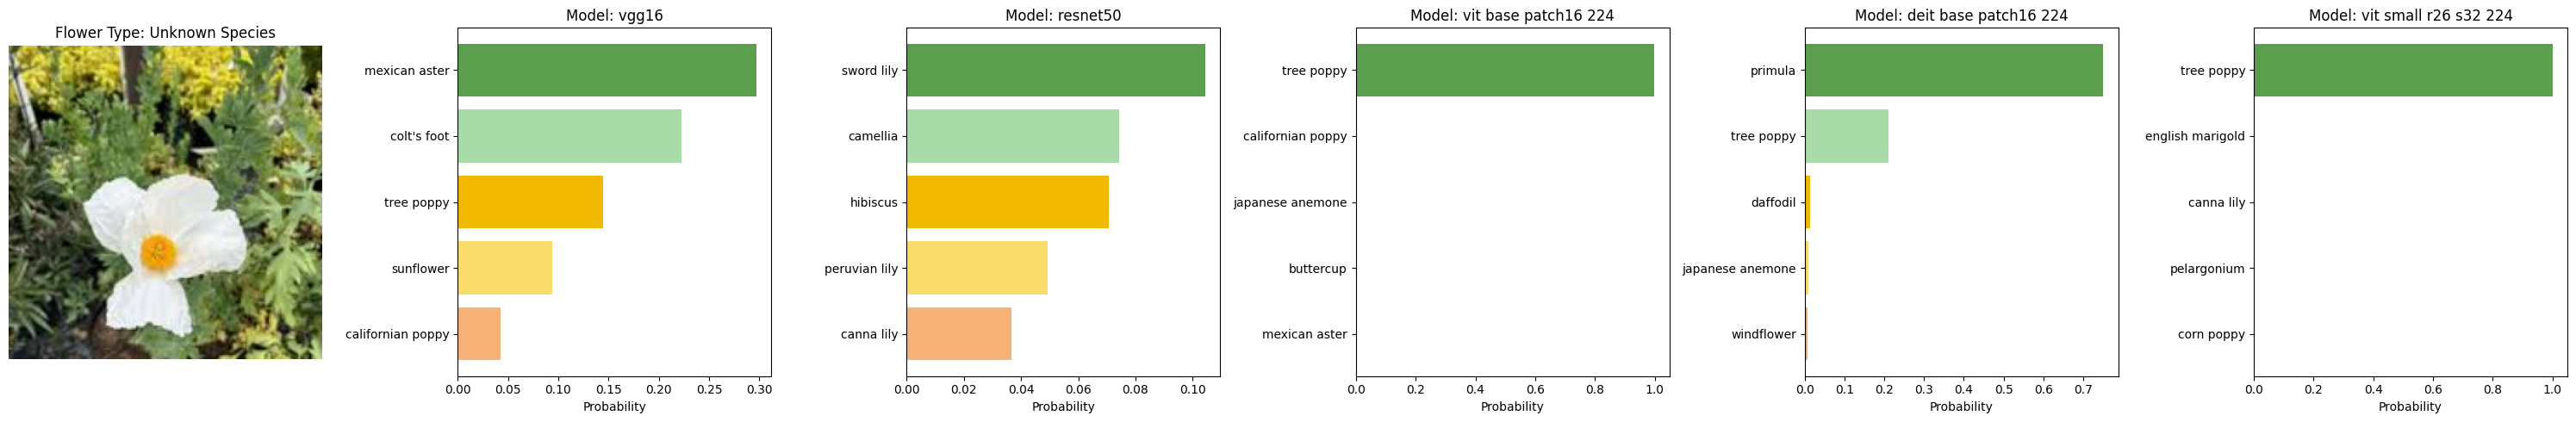

In [ ]:
sanity_checking('assets/Tree Poppy.jpg', models)

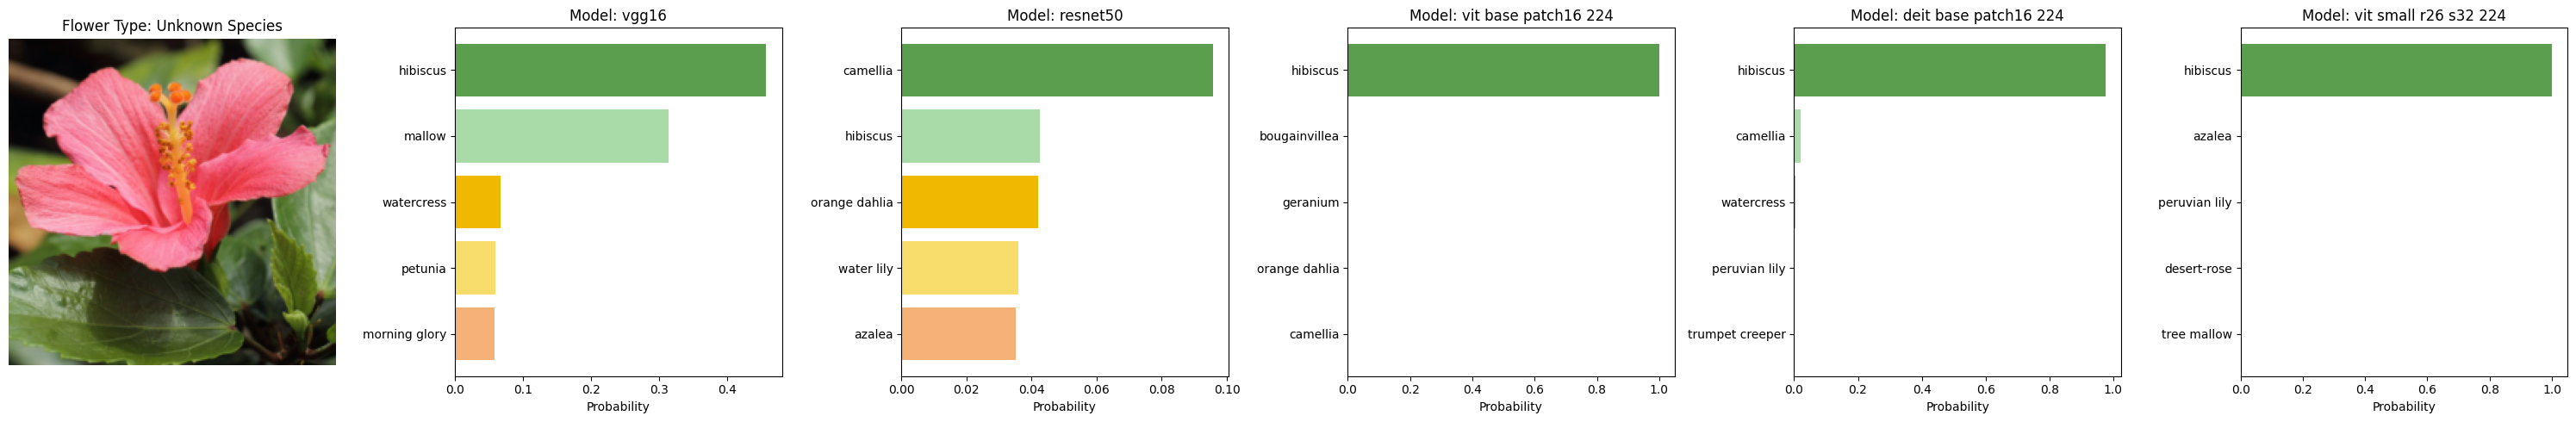

In [ ]:
sanity_checking('assets/Hibiscus.jpg', models)

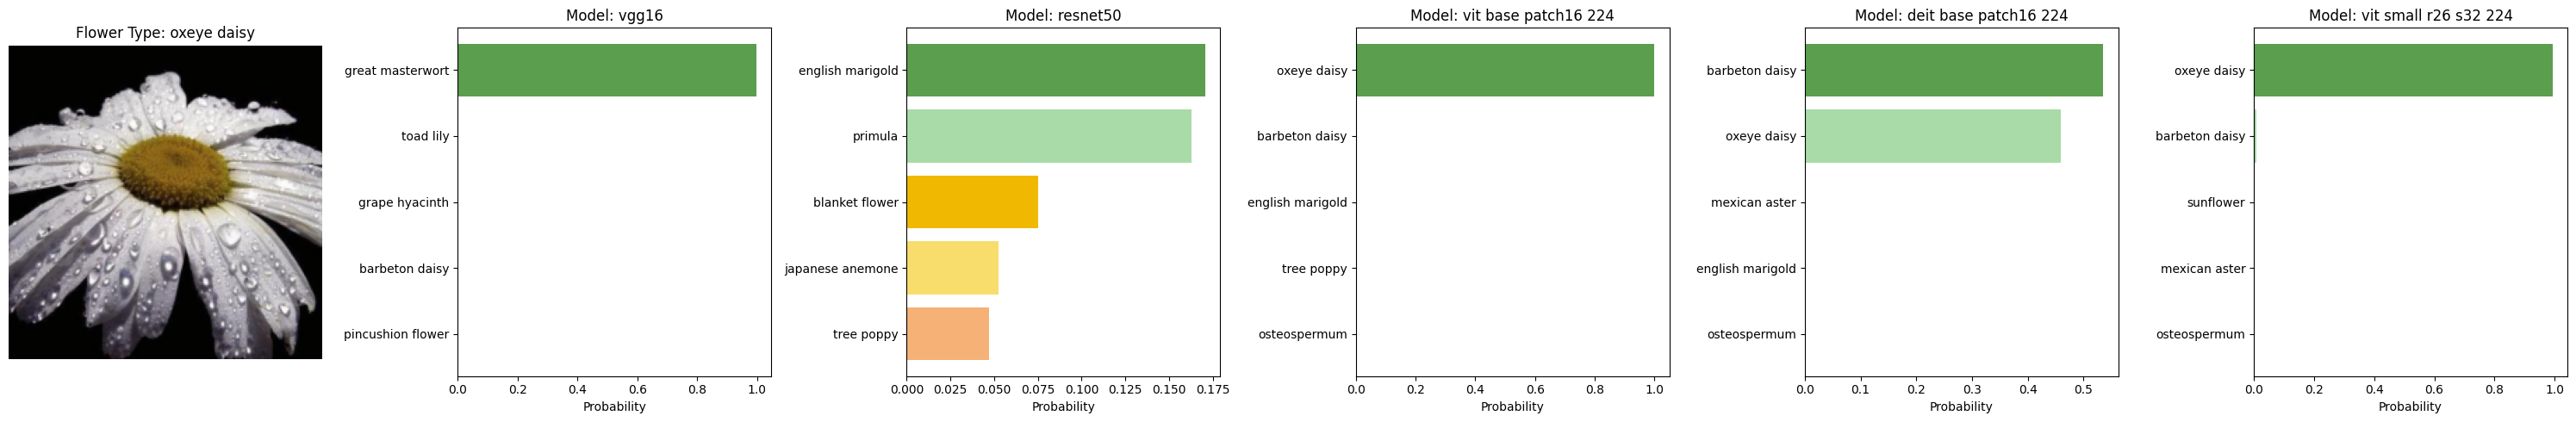

In [ ]:
sanity_checking('flowers/test/49/image_06202.jpg', models)

## 04. Streamlit App

To optimize this process, a Streamlit app has been developed, and you can see the app in action in the video below 🎥.

If you'd like to run the app yourself, download the `Flower Classifier Streamlit.zip`, unzip it and follow the instructions in the `Follow These Steps.txt` file 📂💻.

<br>

<center>
  <a href="https://drive.google.com/uc?export=view&id=1T8oR8aZVjErKRAI7s5fZgFeM3EM5AbNE" target="_blank">
  <img alt='Thumbnail for a video showing 3 AI-powered Google Colab features' src="https://drive.google.com/uc?export=view&id=1uS_SHtyT2QFwQreRt0TwgtOg4T3z8dqW" height="70%" width="70%">
  </a>
</center>